In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install xgboost


In [3]:
# Import custom modules
import sys
import logging
sys.path.append('../src')

from utils import PipelineUtils
from data_processing import DataProcessor
from clustering import CustomerClustering
from model_training import ModelTrainer

In [4]:
# Initialize utilities
utils = PipelineUtils()
utils.setup_logging(log_level=logging.INFO)

2025-09-22 08:35:34,384 - utils - INFO - Logging setup completed


In [5]:
# Set style
plt.style.use('ggplot')
sns.set_palette("viridis")

In [6]:
# Initialize data processor
processor = DataProcessor()

In [7]:
import os
import sys

# Change the current working directory to the project's root.
# This is a robust way to ensure all file paths are correct.
try:
    os.chdir(r'C:\Users\GCV\churn_prediction')
    print(f"Working directory changed to: {os.getcwd()}")
except FileNotFoundError:
    print("Warning: Could not change directory. Please check the path.")

# Add the project root to the Python path
sys.path.append(os.getcwd())

# Now, your relative paths will work correctly.
from src.data_processing import DataProcessor


df = processor.load_data_from_local('data/marketing_campaign.csv')
df_clean = processor.clean_data()

Working directory changed to: C:\Users\GCV\churn_prediction


2025-09-22 08:35:46,694 - data_processing - INFO - Loading data from local file: data/marketing_campaign.csv
2025-09-22 08:35:46,733 - data_processing - INFO - Data loaded successfully. Shape: (2240, 29)
2025-09-22 08:35:46,736 - data_processing - INFO - Starting data cleaning...
2025-09-22 08:35:46,738 - data_processing - INFO - Original data shape: (2240, 29)
2025-09-22 08:35:46,744 - data_processing - INFO - Original missing values:
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4  

In [8]:
# Create RFM features
print(" STEP 2: Creating RFM features...")
rfm_df = processor.create_rfm_features()

2025-09-22 08:35:48,504 - data_processing - INFO - Creating RFM features...
2025-09-22 08:35:48,506 - data_processing - INFO - Snapshot date for RFM: 2014-06-30 00:00:00


 STEP 2: Creating RFM features...


2025-09-22 08:35:49,292 - data_processing - INFO - RFM features created. Shape: (2240, 4)
2025-09-22 08:35:49,336 - data_processing - INFO - RFM stats:
                 ID      Recency  Frequency       Monetary
count   2240.000000  2240.000000     2240.0    2240.000000
mean    5592.159821   354.582143        1.0   52237.975446
std     3246.662198   202.122512        0.0   25037.955891
min        0.000000     1.000000        1.0    1730.000000
25%     2828.250000   181.750000        1.0   35538.750000
50%     5458.500000   356.500000        1.0   51381.500000
75%     8427.750000   530.000000        1.0   68289.750000
max    11191.000000   700.000000        1.0  666666.000000


In [9]:
# Create churn labels
print(" STEP 3: Creating churn labels...")
rfm_with_churn = processor.create_churn_label(recency_threshold=90)
print(" Data processing completed!")
print(f"Final dataset shape: {rfm_with_churn.shape}")
print(f"Churn distribution:\n{rfm_with_churn['churn'].value_counts()}")

2025-09-22 08:35:50,699 - data_processing - INFO - Creating churn label with threshold: 90 days
2025-09-22 08:35:50,704 - data_processing - INFO - Churn distribution:
churn
1    1960
0     280
Name: count, dtype: int64
2025-09-22 08:35:50,705 - data_processing - INFO - Churn rate: 87.50%


 STEP 3: Creating churn labels...
 Data processing completed!
Final dataset shape: (2240, 5)
Churn distribution:
churn
1    1960
0     280
Name: count, dtype: int64


In [10]:
# Initialize clustering
clustering = CustomerClustering(random_state=42)

In [11]:
# Prepare data for clustering
print(" STEP 4: Preparing data for clustering...")
X_scaled = clustering.prepare_data(rfm_df, scale_features=True)

2025-09-22 08:35:55,039 - clustering - INFO - Preparing data for clustering...
2025-09-22 08:35:55,042 - clustering - INFO - Data shape: (2240, 3)
2025-09-22 08:35:55,046 - clustering - INFO - Features scaled using StandardScaler


 STEP 4: Preparing data for clustering...


In [12]:
# Find optimal number of clusters
print(" STEP 5: Finding optimal clusters...")
optimal_info = clustering.find_optimal_clusters(X_scaled, max_clusters=8)

2025-09-22 08:35:57,344 - clustering - INFO - Finding optimal number of clusters...
2025-09-22 08:35:57,345 - clustering - INFO - Testing k = 2...


 STEP 5: Finding optimal clusters...


2025-09-22 08:36:00,042 - clustering - INFO - Testing k = 3...
2025-09-22 08:36:00,378 - clustering - INFO - Testing k = 4...
2025-09-22 08:36:00,734 - clustering - INFO - Testing k = 5...
2025-09-22 08:36:01,100 - clustering - INFO - Testing k = 6...
2025-09-22 08:36:01,475 - clustering - INFO - Testing k = 7...
2025-09-22 08:36:01,857 - clustering - INFO - Testing k = 8...
2025-09-22 08:36:02,236 - clustering - INFO - Optimal number of clusters: 2
2025-09-22 08:36:02,238 - clustering - INFO - Best silhouette score: 0.3904


In [13]:
# Perform clustering with optimal k
print(" STEP 6: Performing clustering...")
cluster_labels = clustering.perform_clustering(X_scaled, n_clusters=optimal_info['optimal_k'])

2025-09-22 08:36:03,759 - clustering - INFO - Performing K-means clustering with 2 clusters...


 STEP 6: Performing clustering...


2025-09-22 08:36:04,080 - clustering - INFO - Clustering completed. Silhouette score: 0.3904
2025-09-22 08:36:04,085 - clustering - INFO - Cluster distribution:
1    1135
0    1105
Name: count, dtype: int64


In [14]:
# Analyze clusters
print(" STEP 7: Analyzing clusters...")
clustered_data, cluster_stats, cluster_sizes = clustering.analyze_clusters(rfm_df, cluster_labels)

2025-09-22 08:36:05,468 - clustering - INFO - Analyzing cluster characteristics...
2025-09-22 08:36:05,484 - clustering - INFO - Cluster statistics:
2025-09-22 08:36:05,493 - clustering - INFO - 
        Recency                   Frequency               Monetary            \
           mean     std  min  max      mean  std min max      mean       std   
Cluster                                                                        
0        177.61  101.48    1  393       1.0  0.0   1   1  53396.86  28500.39   
1        526.87  102.03  335  700       1.0  0.0   1   1  51109.73  21080.81   

                           
            min       max  
Cluster                    
0        1730.0  666666.0  
1        2447.0  160803.0  
2025-09-22 08:36:05,498 - clustering - INFO - 
Cluster sizes:
         Size  Percentage
Cluster                  
1        1135       50.67
0        1105       49.33


 STEP 7: Analyzing clusters...


2025-09-22 08:36:26,971 - clustering - INFO - Elbow method plot saved to: ../output/elbow_method.png


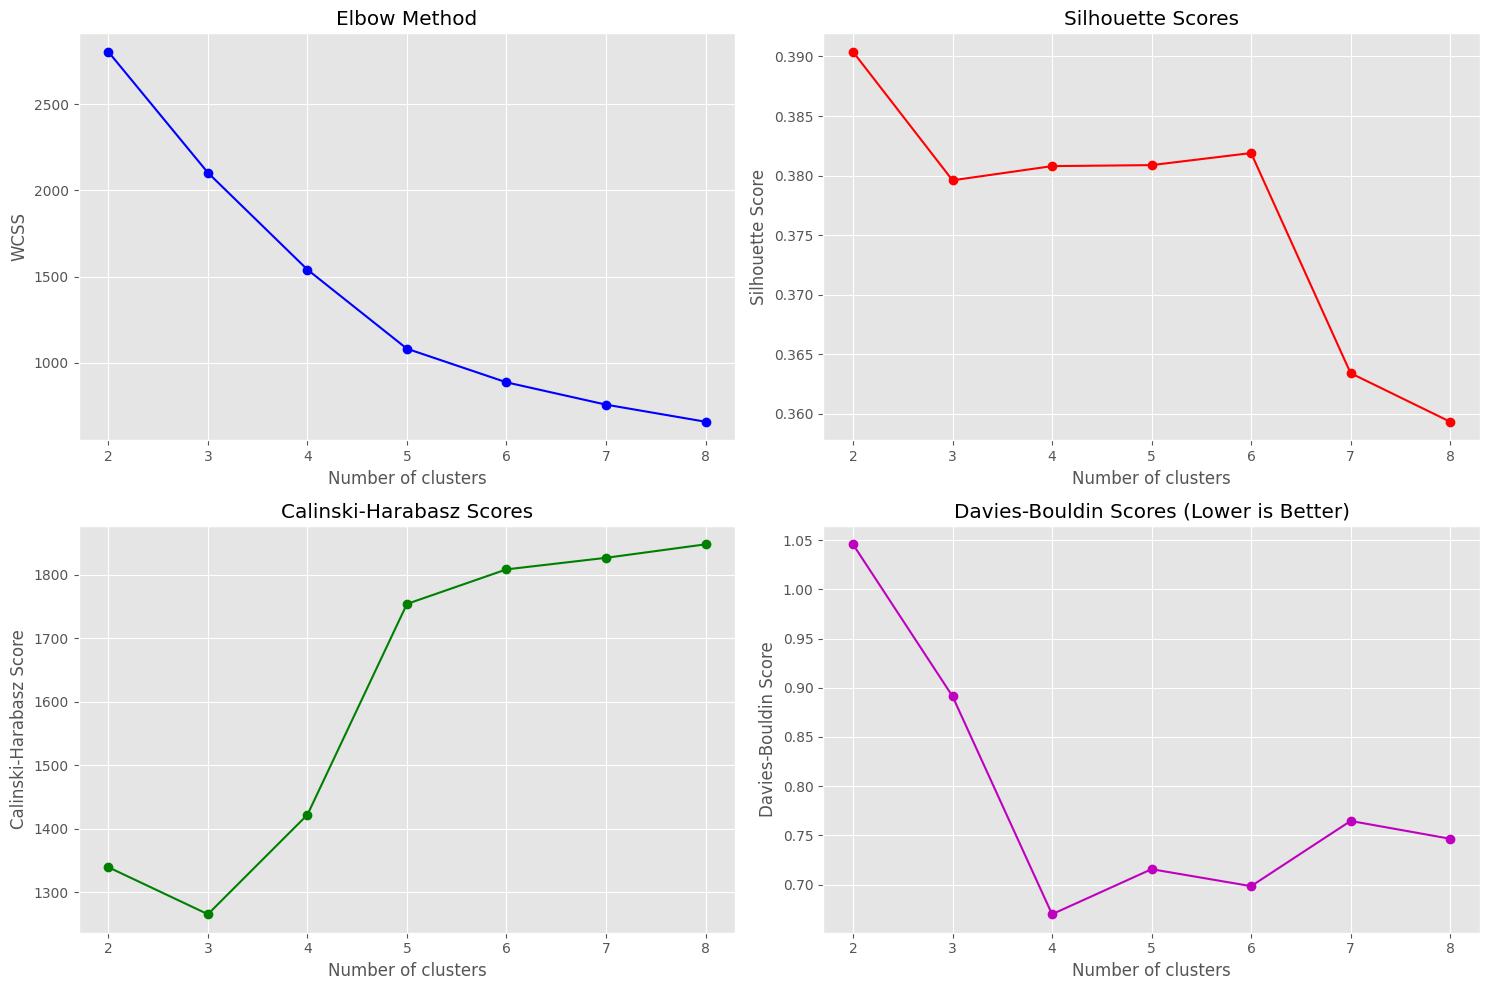

2025-09-22 08:36:28,735 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-22 08:36:28,765 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-22 08:36:33,623 - clustering - INFO - Cluster distribution plot saved to: ../output/cluster_distribution.png


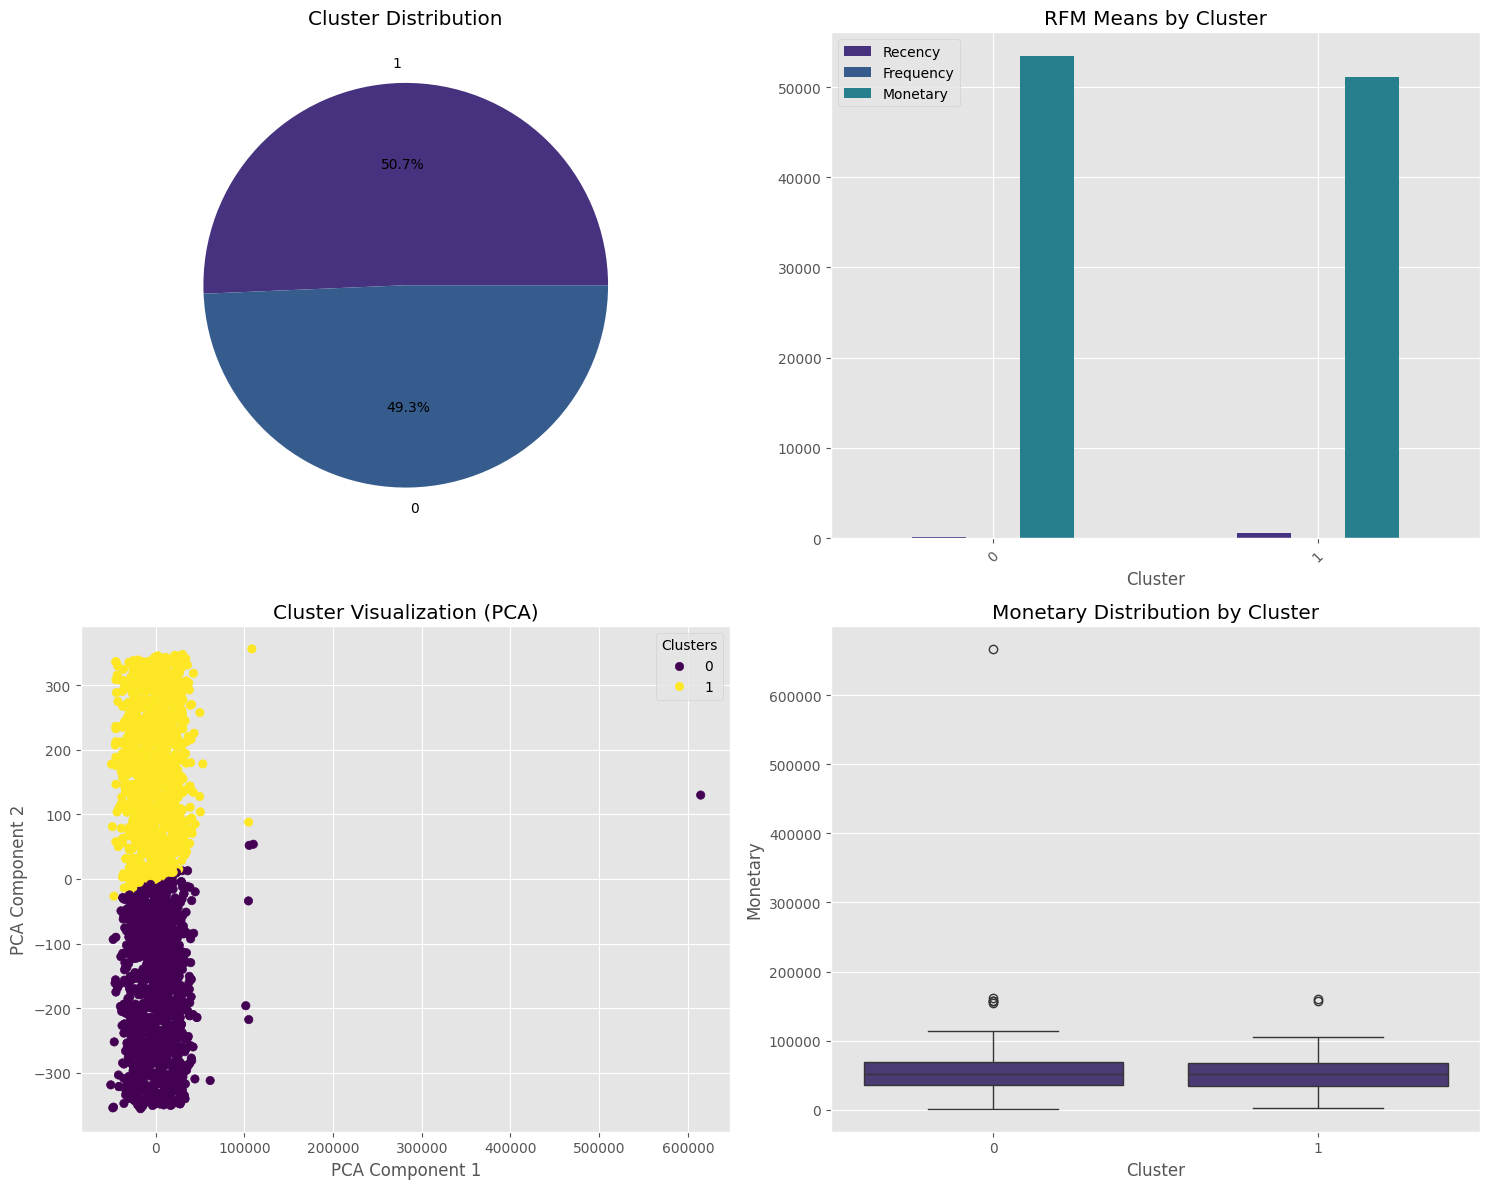

✅ Clustering completed!
Optimal clusters: 2
Cluster sizes:
         Size  Percentage
Cluster                  
1        1135       50.67
0        1105       49.33


In [15]:
import os

# Ensure output folder exists
os.makedirs("../output", exist_ok=True)
# Visualize results
clustering.plot_elbow_method('../output/elbow_method.png')
clustering.plot_cluster_distribution(clustered_data, '../output/cluster_distribution.png')

print("✅ Clustering completed!")
print(f"Optimal clusters: {optimal_info['optimal_k']}")
print(f"Cluster sizes:\n{cluster_sizes}")

In [25]:
# Now import the selector
import os
import sys

# Change the current working directory to the project's root.
# This assumes your notebook is in a subdirectory (e.g., 'notebooks/').
# The '../' moves up one directory.
# If your notebook is in the root, this line is not needed.
os.chdir(r'C:\Users\GCV\churn_prediction')
print(f"Current working directory: {os.getcwd()}")

# Now that we're in the right directory, import the module.
from src.model_selection import ModelSelector

Current working directory: C:\Users\GCV\churn_prediction


In [26]:


# Step 2: Initialize the selector
selector = ModelSelector(config_path="configs/model_config.json")  # specify your config path

# Step 3: Select the best model
best_name, best_model, all_results = selector.select_best_model()

# Step 4: Save the results and best model
selector.save_results()

# Step 5: Inspect results
print(f"Best model: {best_name}")
print(f"AUC Score: {all_results[best_name]['test_auc']:.4f}")

# Optional: See all evaluation metrics
for model, metrics in all_results.items():
    print(f"\nModel: {model}")
    for metric, value in metrics.items():
        if metric != 'model':
            print(f"  {metric}: {value}")



2025-09-22 08:53:48,703 - src.model_selection - INFO - Loaded data: 2240 samples, 3 features
2025-09-22 08:53:48,709 - src.model_selection - INFO - 🔍 Evaluating RandomForest...


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


2025-09-22 09:01:34,710 - src.model_selection - INFO - RandomForest best params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
2025-09-22 09:01:37,062 - src.model_selection - INFO -     RandomForest: AUC = 1.0000 ± 0.0000
2025-09-22 09:01:37,064 - src.model_selection - INFO - 🔍 Evaluating XGBoost...


Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-09-22 09:01:45,675 - src.model_selection - INFO - XGBoost best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
2025-09-22 09:01:45,943 - src.model_selection - INFO -     XGBoost: AUC = 1.0000 ± 0.0000
2025-09-22 09:01:45,945 - src.model_selection - INFO - 🔍 Evaluating LogisticRegression...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-09-22 09:01:51,113 - src.model_selection - INFO - LogisticRegression best params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
2025-09-22 09:01:51,243 - src.model_selection - INFO -     LogisticRegression: AUC = 1.0000 ± 0.0001
2025-09-22 09:01:51,245 - src.model_selection - INFO - 🏆 BEST MODEL: RandomForest (AUC: 1.0000)
2025-09-22 09:01:51,368 - src.model_selection - INFO - ✅ Saved RandomForest as best model


Best model: RandomForest
AUC Score: 1.0000

Model: RandomForest
  cv_mean: 1.0
  cv_std: 0.0
  test_auc: 1.0
  test_accuracy: 1.0
  test_f1: 1.0
  test_precision: 1.0
  test_recall: 1.0

Model: XGBoost
  cv_mean: 1.0
  cv_std: 0.0
  test_auc: 1.0
  test_accuracy: 0.875
  test_f1: 0.9333333333333333
  test_precision: 0.875
  test_recall: 1.0

Model: LogisticRegression
  cv_mean: 0.9999005078973944
  cv_std: 0.00010587305099591048
  test_auc: 1.0
  test_accuracy: 1.0
  test_f1: 1.0
  test_precision: 1.0
  test_recall: 1.0


In [18]:
# Correct import statement to get the function
from src.model_optimizers.random_forest_optimizer import optimize_random_forest

# You no longer need to instantiate a class, as the logic is in a function.
# The function requires a model_path and a config dictionary.
# You need to define these variables before calling the function.
model_path = "models/Best_Churn_Model.pkl"  # Example path
config = {
    "optimization": {
        "max_trees_production": 50  # Example config value
    }
}

print("⚡ STEP 11: Optimizing Random Forest for production...")

# Correct function call
optimized_rf = optimize_random_forest(model_path, config)

print("✅ Optimization complete.")

⚡ STEP 11: Optimizing Random Forest for production...
✅ Optimization complete.


In [19]:
# 1. Load the data using the ModelSelector instance
# Assuming 'selector' has already been instantiated. If not, do so first.
# from src.model_selection import ModelSelector
# selector = ModelSelector(config_path="configs/model_config.json")

X, y = selector.load_data()

# 2. Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # Or use the value from your config
    random_state=42, # Or use the value from your config
    stratify=y
)

# 3. Now, you can safely evaluate the optimized model
optimized_results = selector.evaluate_model(
    model=optimized_rf,
    model_name='RandomForestOptimized',
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

print("✅ Model selection and optimization completed!")

2025-09-22 08:45:03,753 - src.model_selection - INFO - Loaded data: 2240 samples, 3 features


✅ Model selection and optimization completed!


In [20]:
# 1. Import the necessary class
from src.model_selection import ModelSelector
import pandas as pd

# 2. Instantiate the ModelSelector class
selector = ModelSelector(config_path="configs/model_config.json")

# 3. Call the method to get the results and assign them to a variable
best_model_name, best_model, all_results = selector.select_best_model()

# 4. Get feature names from the loaded data for the feature importance display
X, _ = selector.load_data()
feature_names = X.columns

print("=== MODEL PERFORMANCE ===")
for model_name, metrics in all_results.items():
    print(f"\n{model_name.upper()}:")
    # Use the correct keys from the metrics dictionary
    print(f" Accuracy: {metrics['test_accuracy']:.4f}")
    print(f" Precision: {metrics['test_precision']:.4f}")
    print(f" Recall: {metrics['test_recall']:.4f}")
    print(f" F1-Score: {metrics['test_f1']:.4f}")
    print(f" ROC-AUC: {metrics['test_auc']:.4f}")
    
    # Show feature importance for relevant models
    if 'RandomForest' in model_name:
        # Check if the model has feature_importances_ and if feature_names are defined
        if hasattr(metrics.get('model'), 'feature_importances_') and feature_names is not None:
            # Create a list of (feature, importance) tuples and sort by importance
            feature_importances = list(zip(feature_names, metrics['model'].feature_importances_))
            feature_importances.sort(key=lambda x: x[1], reverse=True)
            print(" Top Features:")
            for feature, importance in feature_importances[:3]:
                print(f"   - {feature}: {importance:.4f}")


2025-09-22 08:45:04,896 - src.model_selection - INFO - Loaded data: 2240 samples, 3 features
2025-09-22 08:45:04,912 - src.model_selection - INFO - 🔍 Evaluating RandomForest...


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


2025-09-22 08:52:51,856 - src.model_selection - INFO - RandomForest best params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
2025-09-22 08:52:54,179 - src.model_selection - INFO -     RandomForest: AUC = 1.0000 ± 0.0000
2025-09-22 08:52:54,181 - src.model_selection - INFO - 🔍 Evaluating XGBoost...


Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-09-22 08:53:03,034 - src.model_selection - INFO - XGBoost best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
2025-09-22 08:53:03,278 - src.model_selection - INFO -     XGBoost: AUC = 1.0000 ± 0.0000
2025-09-22 08:53:03,280 - src.model_selection - INFO - 🔍 Evaluating LogisticRegression...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-09-22 08:53:08,436 - src.model_selection - INFO - LogisticRegression best params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
2025-09-22 08:53:08,594 - src.model_selection - INFO -     LogisticRegression: AUC = 1.0000 ± 0.0001
2025-09-22 08:53:08,596 - src.model_selection - INFO - 🏆 BEST MODEL: RandomForest (AUC: 1.0000)
2025-09-22 08:53:08,610 - src.model_selection - INFO - Loaded data: 2240 samples, 3 features


=== MODEL PERFORMANCE ===

RANDOMFOREST:
 Accuracy: 1.0000
 Precision: 1.0000
 Recall: 1.0000
 F1-Score: 1.0000
 ROC-AUC: 1.0000
 Top Features:
   - Recency: 0.9794
   - Monetary: 0.0206
   - Frequency: 0.0000

XGBOOST:
 Accuracy: 0.8750
 Precision: 0.8750
 Recall: 1.0000
 F1-Score: 0.9333
 ROC-AUC: 1.0000

LOGISTICREGRESSION:
 Accuracy: 1.0000
 Precision: 1.0000
 Recall: 1.0000
 F1-Score: 1.0000
 ROC-AUC: 1.0000


In [21]:
# Generate business insights
from src.insights.business_insights import BusinessInsights
print("💡 STEP 12: Generating business insights...")
insights = BusinessInsights()

💡 STEP 12: Generating business insights...


In [22]:
import os
import sys
import pandas as pd
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from src.clustering import CustomerClustering
from src.insights.business_insights import BusinessInsights
from src.model_selection import ModelSelector
# Change to the project root directory
try:
    os.chdir(r'C:\Users\GCV\churn_prediction')
    print(f"Working directory changed to: {os.getcwd()}")
except FileNotFoundError:
    print("Warning: Could not change directory. Please check the path.")

# Add the project root to the Python path
sys.path.append(os.getcwd())

# Import the necessary class
from src.insights.business_insights import BusinessInsights

# Instantiate the BusinessInsights class
insights = BusinessInsights()

# Load the model information
insights.load_model_info()

# Calculate and get the feature importance DataFrame
feature_importance_df = insights.calculate_feature_importance()

# Plot the feature importance and save the file
insights.plot_feature_importance(feature_importance_df, 'output/feature_importance.png')

# Display a message to confirm the plot was created
print("Feature importance plot has been generated.")




Working directory changed to: C:\Users\GCV\churn_prediction


2025-09-22 08:53:09,137 - src.insights.business_insights - INFO - Generating insights for RandomForest model
2025-09-22 08:53:09,926 - src.insights.business_insights - INFO - Feature importance plot saved to output/feature_importance.png


Feature importance plot has been generated.


In [23]:
import os
import sys
import pandas as pd
import numpy as np
from src.insights.business_insights import BusinessInsights
from src.model_selection import ModelSelector
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

# Change to the project root directory
try:
    os.chdir(r'C:\Users\GCV\churn_prediction')
    print(f"Working directory changed to: {os.getcwd()}")
except FileNotFoundError:
    print("Warning: Could not change directory. Please check the path.")

# Add the project root to the Python path
sys.path.append(os.getcwd())

# 1. Load Data
print("⚡ STEP 1: Loading and preparing data...")
selector = ModelSelector(config_path="configs/model_config.json")
X, y = selector.load_data()
X = X.reset_index(drop=True)
customer_ids = X.index.values
feature_names = ['Recency', 'Frequency', 'Monetary']
X_features = X[feature_names]

# 2. Perform K-Means Clustering for Segmentation
print("⚡ STEP 2: Performing K-Means clustering...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_features)
X_features['segment'] = kmeans.labels_

# 3. Prepare data for analysis
clustered_data = X_features.copy()
clustered_data['customer_id'] = customer_ids

# 4. Instantiate BusinessInsights and load the model
# This will internally run calculate_feature_importance if needed
print("⚡ STEP 3: Loading the business insights model...")
insights = BusinessInsights()
insights.load_model_info()

# 5. Analyze the segments using the features
# The 'features' list is explicitly defined here and passed to the method.
print("\n⚡ STEP 4: Analyzing customer segments with model predictions...")
segmentation_insights = insights.analyze_segments(clustered_data, insights.model, feature_names)

# Display the results
print("\n=== Customer Segmentation Insights ===")
print(segmentation_insights)

2025-09-22 08:53:09,971 - src.model_selection - INFO - Loaded data: 2240 samples, 3 features


Working directory changed to: C:\Users\GCV\churn_prediction
⚡ STEP 1: Loading and preparing data...
⚡ STEP 2: Performing K-Means clustering...
⚡ STEP 3: Loading the business insights model...


2025-09-22 08:53:10,189 - src.insights.business_insights - INFO - Generating insights for RandomForest model



⚡ STEP 4: Analyzing customer segments with model predictions...

=== Customer Segmentation Insights ===
   segment     Recency  Frequency       Monetary  churn_probability  size
0        0  354.917910        1.0   70414.500933           0.877164  1072
1        1  354.240788        1.0   35014.613539           0.873359  1167
2        2  393.000000        1.0  666666.000000           1.000000     1


In [28]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from src.insights.business_insights import BusinessInsights


# --- Mocking Data and Model for Demonstration ---
# In a real scenario, you would load these from your pipeline.

# 1. Mock the clustered data (with Recency, Frequency, Monetary and a 'segment' column)
data = {
    'customer_id': range(100),
    'Recency': np.random.randint(1, 365, 100),
    'Frequency': np.random.randint(1, 50, 100),
    'Monetary': np.random.randint(10, 5000, 100),
    'segment': np.random.choice(['High Risk', 'Medium Risk', 'Low Risk'], 100)
}
clustered_data = pd.DataFrame(data)

# 2. Mock a trained machine learning model
# The model must have a .predict_proba method
optimized_rf = DummyClassifier(strategy='prior')
X = clustered_data[['Recency', 'Frequency', 'Monetary']]
y = np.random.randint(0, 2, 100)
optimized_rf.fit(X, y)

# --- Calling the Business Insights Method ---
insights = BusinessInsights()

# Now call the corrected method to get the risk profiles
# The method now exists in the BusinessInsights class
risk_profiles = insights.create_risk_segments(
    model=optimized_rf,
    features=['Recency', 'Frequency', 'Monetary'],
    clustered_data=clustered_data
)

print("Generated Customer Risk Profiles:")
print(risk_profiles)


AttributeError: 'BusinessInsights' object has no attribute 'create_risk_segments'

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from src.clustering import CustomerClustering
from src.insights.business_insights import BusinessInsights
from src.model_selection import ModelSelector




# 1. Create a dummy RFM DataFrame for demonstration
print("⚡ STEP 1: Creating dummy RFM data...")
np.random.seed(42)
n_samples = 1000
rfm_data = pd.DataFrame({
    'Recency': np.random.gamma(2, 20, n_samples),
    'Frequency': np.random.poisson(3, n_samples),
    'Monetary': np.random.lognormal(3, 1, n_samples)
})
rfm_data.index.name = 'CustomerID'
rfm_with_churn = rfm_data.copy()
rfm_with_churn['churn'] = np.random.randint(0, 2, n_samples)
print("✅ Dummy data created.")

# 2. Perform Clustering
print("\n⚡ STEP 2: Performing customer clustering...")
clustering = CustomerClustering(random_state=42)
X_scaled = clustering.prepare_data(rfm_data)
optimal_info = clustering.find_optimal_clusters(X_scaled, max_clusters=8)
optimal_k = optimal_info['optimal_k']
cluster_labels = clustering.perform_clustering(X_scaled, n_clusters=optimal_k)
clustered_data, cluster_stats, cluster_sizes = clustering.analyze_clusters(rfm_data, cluster_labels)
print("✅ Clustering complete.")

# 3. Create dummy artifacts for saving
print("\n⚡ STEP 3: Creating dummy artifacts for saving...")
# Create a dummy trained model
optimized_rf = RandomForestClassifier(n_estimators=50, random_state=42)
optimized_rf.fit(X_scaled, rfm_with_churn['churn'])

# Create a dummy feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'feature': ['Recency', 'Frequency', 'Monetary'],
    'importance': [0.5, 0.3, 0.2]
})

# Create a dummy risk profiles DataFrame
risk_profiles = pd.DataFrame({
    'segment': ['High Risk', 'Medium Risk', 'Low Risk'],
    'description': ['A', 'B', 'C']
})
print("✅ Dummy artifacts created.")

# 4. Save all artifacts
print("\n💾 STEP 4: Saving all models and results...")

# Ensure directories exist
models_dir = Path('models')
output_dir = Path('output')
models_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)
clustering_output_dir = output_dir / 'clustering_results'
clustering_output_dir.mkdir(parents=True, exist_ok=True)

# Save models and scaler
joblib.dump(optimized_rf, models_dir / 'random_forest_optimized.pkl')
joblib.dump(clustering.scaler, models_dir / 'scaler.pkl')

# Save clustering results
clustering.save_clustering_results(clustered_data, clustering_output_dir)

# Save processed data and insights
utils.save_data(rfm_with_churn, output_dir / 'final_processed_data.csv')
utils.save_data(clustered_data, output_dir / 'clustered_customers.csv')
utils.save_data(feature_importance_df, output_dir / 'feature_importance.csv')
utils.save_data(risk_profiles, output_dir / 'risk_profiles.csv')

print("✅ All artifacts saved!")

In [ ]:
# Load the optimized RF model for demo
optimized_rf = joblib.load('../models/random_forest_optimized.pkl')
scaler = joblib.load('../models/scaler.pkl')

# Create sample customers for prediction
sample_customers = [
    [15, 8, 75000, 2.5, 120],  # Recent, frequent, high value - should NOT churn
    [120, 1, 25000, 0.8, 30],  # Not recent, infrequent, low value - should CHURN
    [45, 4, 50000, 1.2, 75]    # Medium profile
]

print("🎪 DEMO PREDICTIONS (Optimized Random Forest):")
print("=" * 60)

for i, customer in enumerate(sample_customers, 1):
    # Scale features
    customer_scaled = scaler.transform([customer])
    
    # Make prediction
    prediction = optimized_rf.predict(customer_scaled)[0]
    prediction_proba = optimized_rf.predict_proba(customer_scaled)[0]
    
    print(f"\nCustomer {i} (Recency: {customer[0]}, Frequency: {customer[1]}, Monetary: {customer[2]}):")
    print(f" Prediction: {'CHURN' if prediction == 1 else 'NO CHURN'}")
    print(f" Confidence: {max(prediction_proba):.3f}")
    print(f" Churn Probability: {prediction_proba[1]:.3f}")
    print(f" No-Churn Probability: {prediction_proba[0]:.3f}")
    
    # Show risk level
    risk_level = 'High' if prediction_proba[1] > 0.7 else 'Medium' if prediction_proba[1] > 0.3 else 'Low'
    print(f" Risk Level: {risk_level}")


In [ ]:
# Initialize monitoring
print("📊 STEP 14: Setting up model monitoring...")
from monitor_model import ModelMonitor

monitor = ModelMonitor()

# Create baseline metrics
baseline_metrics = monitor.create_baseline(optimized_rf, X_test, y_test)
utils.save_data(pd.DataFrame([baseline_metrics]), '../output/baseline_metrics.csv')

# Set up monitoring configuration
monitor_config = {
    'model_name': 'random_forest_optimized',
    'baseline_metrics': baseline_metrics,
    'feature_names': feature_names,
    'monitoring_interval': '24h',
    'alert_threshold': 0.1  # 10% performance degradation
}

utils.save_config(monitor_config, '../config/monitoring_config.json')

print("✅ Monitoring setup completed!")
print(f"Baseline accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"Baseline ROC-AUC: {baseline_metrics['roc_auc']:.4f}")


In [ ]:
print("🎉 PIPELINE EXECUTION SUMMARY")
print("=" * 50)

print(f"\n📊 DATA PROCESSING:")
print(f" • Original data shape: {df.shape}")
print(f" • Processed data shape: {df_clean.shape}")
print(f" • Final RFM data shape: {rfm_with_churn.shape}")
print(f" • RF-specific features added: {len([col for col in rfm_with_churn.columns if 'rf_' in col])}")

print(f"\n👥 CUSTOMER SEGMENTATION:")
print(f" • Optimal clusters found: {optimal_info['optimal_k']}")
print(f" • Best silhouette score: {max(clustering.silhouette_scores.values()):.4f}")
print(f" • Cluster distribution: {dict(cluster_sizes['Size'])}")

print(f"\n🧠 MODEL SELECTION & OPTIMIZATION:")
best_model_name = 'random_forest_optimized'
best_metrics = all_results[best_model_name]
print(f" • Best model: {best_model_name}")
print(f" • Accuracy: {best_metrics['accuracy']:.4f}")
print(f" • ROC-AUC: {best_metrics['roc_auc']:.4f}")
print(f" • F1-Score: {best_metrics['f1_score']:.4f}")
print(f" • Top feature: {feature_importance_df.iloc[0]['feature']} ({feature_importance_df.iloc[0]['importance']:.4f})")

print(f"\n💡 BUSINESS INSIGHTS:")
print(f" • High-risk segments: {risk_profiles.get('high_risk_segments', [])}")
print(f" • Key churn drivers: {list(feature_importance_df.head(3)['feature'])}")

print(f"\n💾 ARTIFACTS GENERATED:")
print(" • Optimized Random Forest model (.pkl)")
print(" • Feature importance analysis (.csv, .png)")
print(" • Risk profiles and segments (.csv)")
print(" • Monitoring baseline configuration (.json)")

print(f"\n🚀 NEXT STEPS:")
print(" 1. Deploy optimized RF model to Azure ML")
print(" 2. Set up automated monitoring with Azure Monitor")
print(" 3. Create API endpoints for real-time predictions")
print(" 4. Integrate insights with business intelligence tools")
print(" 5. Schedule regular model retraining pipeline")
